# Monte Carlo Prediction

In [1]:
import sys
import gym
import numpy as np
from collections import defaultdict
from plot_utils import plot_blackjack_values, plot_policy

In [2]:
env = gym.make('Blackjack-v0')

[2022-05-11 09:51:09,689] Making new env: Blackjack-v0
/home/ubuntu/anaconda3/lib/python3.9/site-packages/gym/envs/registration.py:17: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [3]:
def play_episode(env):
    """
    Plays a single episode with a set policy in the environment given. Records the state, action 
    and reward for each step and returns the all timesteps for the episode.
    """
    episode = []
    state = env.reset()
    while True:
        probs = [0.8, 0.2] if state[0] > 18 else [0.2, 0.8]
        action = np.random.choice(np.arange(2), p=probs)
        next_state, reward, done, info = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

In [4]:
def update_Q(episode, Q,returns_sum, N, gamma=1.0):
    """
    For each time step in the episode we carry out the first visit monte carlo method, checking if this is 
    the first index of this state. Get the discounted reward and add it to the total reward for that 
    state/action pair. Increment the times we have seen this state action pair and finally update the Q values
    """
    
    for s, a, r in episode:
            first_occurence_idx = next(i for i,x in enumerate(episode) if x[0] == s)
            G = sum([x[2]*(gamma**i) for i,x in enumerate(episode[first_occurence_idx:])])
            returns_sum[s][a] += G
            N[s][a] += 1.0
            Q[s][a] = returns_sum[s][a] / N[s][a]

In [5]:
def mc_predict(env, num_episodes, gamma=1.0):

    """
    This is the primary method. Plays through several episodes of the environment. 
    """
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    for i_episode in range(1, num_episodes+1):
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
            
        episode = play_episode(env)

        update_Q(episode, Q, returns_sum, N)
            
    return Q   

Episode 500000/500000.

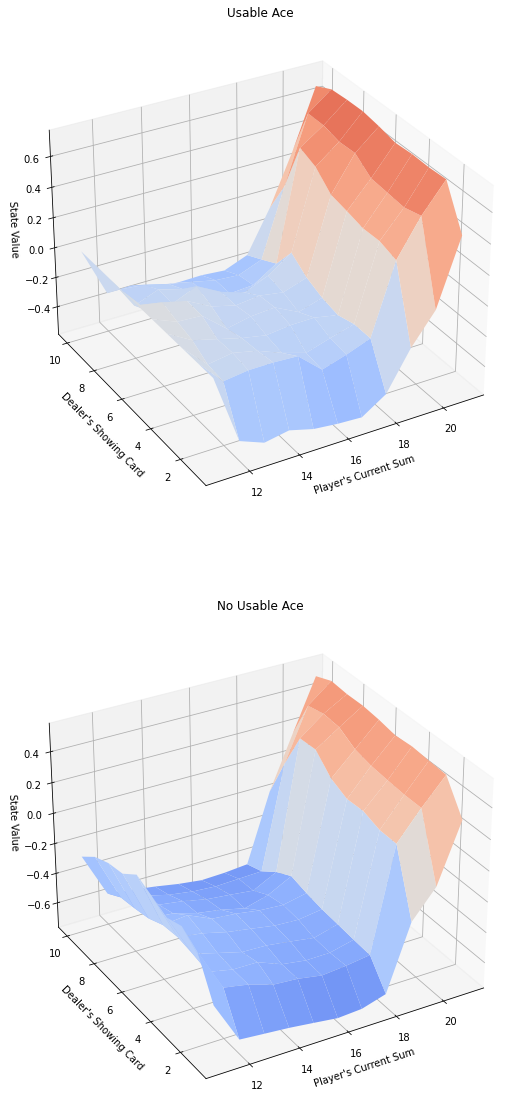

In [6]:
#predict the policy values for our test policy
Q = mc_predict(env, 500000)

#get the state value function for our test policy
V_to_plot = dict((k,(k[0]>18)*(np.dot([0.8, 0.2],v)) + (k[0]<=18)*(np.dot([0.2, 0.8],v))) \
         for k, v in Q.items())

# plot the state value functions
plot_blackjack_values(V_to_plot)